In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import matplotlib.font_manager as fm

# 讀取 CSV 文件
df = pd.read_csv('/Users/ccit0915/Desktop/kaggle/Forecasting Sticker Sales/train.csv', encoding='utf-8')
df

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


In [6]:
import pandas as pd 

# 檢查資料型態和缺失值
print(df.info())

# 檢查數值型資料的統計描述
print(df.describe())

# 檢查各欄位的缺失值
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB
None
                  id       num_sold
count  230130.000000  221259.000000
mean   115064.500000     752.527382
std     66432.953062     690.165445
min         0.000000       5.000000
25%     57532.250000     219.000000
50%    115064.500000     605.000000
75%    172596.750000    1114.000000
max    230129.000000    5939.000000
id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64


In [8]:
missing_ratio = df['num_sold'].isnull().mean()
print(f"'num_sold' 缺失值比例: {missing_ratio:.2%}")

'num_sold' 缺失值比例: 3.85%


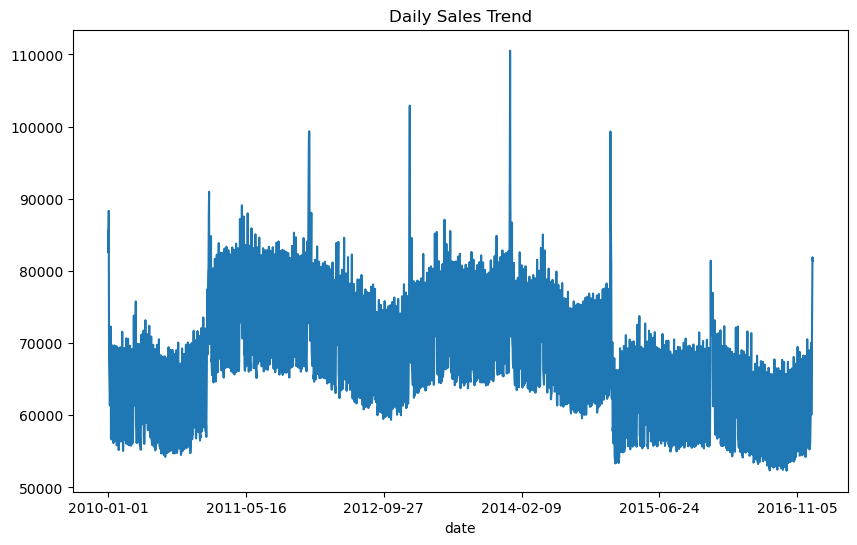

In [10]:
daily_sales = df.groupby('date')['num_sold'].sum()
daily_sales.plot(title='Daily Sales Trend', figsize=(10, 6))
plt.show()

In [11]:
# 使用中位數填補缺失值
median_value = df['num_sold'].median()
df['num_sold'].fillna(median_value, inplace=True)

# 確認是否還有缺失值
missing_ratio = df['num_sold'].isnull().mean()
print(f"'num_sold' 欄位缺失值比例: {missing_ratio:.2%}")

'num_sold' 欄位缺失值比例: 0.00%


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




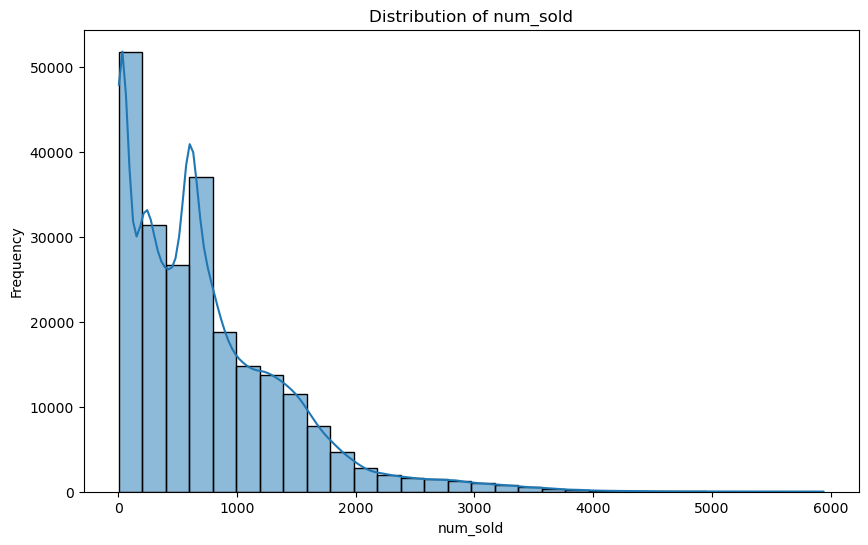

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假設 df 是已經載入的 DataFrame 並且包含 'date' 和 'num_sold' 欄位
# 轉換 'date' 欄位為 datetime 格式
df['date'] = pd.to_datetime(df['date'])

# 從 'date' 欄位提取年、月、日特徵
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# 畫出 'num_sold' 變數的數據分佈
plt.figure(figsize=(10, 6))
sns.histplot(df['num_sold'], kde=True, bins=30)
plt.title('Distribution of num_sold')
plt.xlabel('num_sold')
plt.ylabel('Frequency')
plt.show()

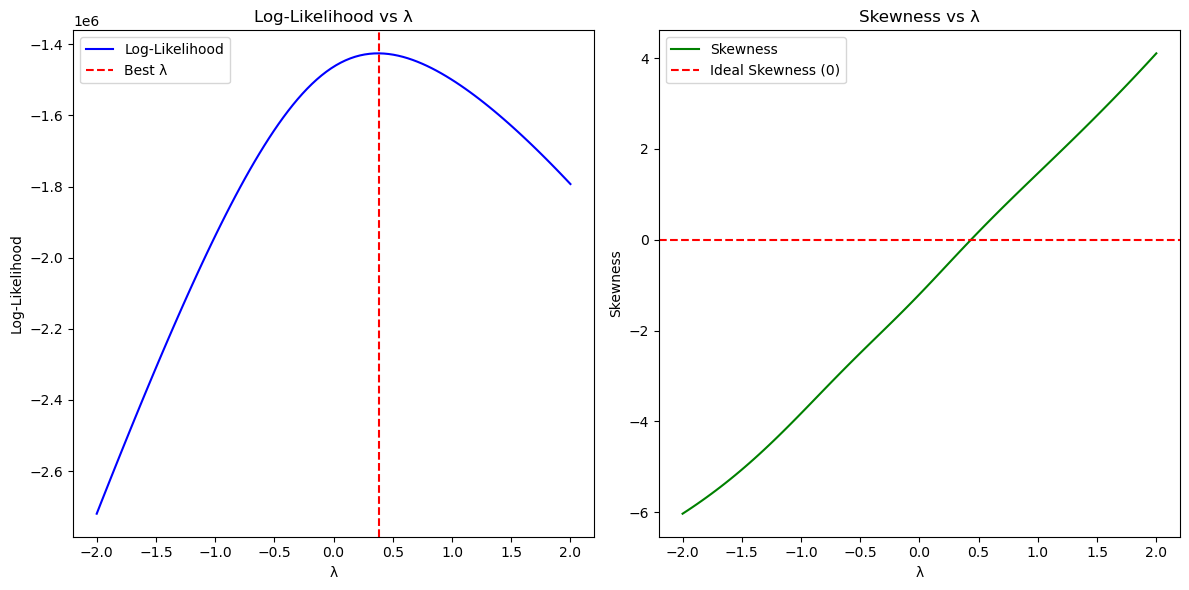

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.special import boxcox1p

# 測試的 λ 值範圍
lambda_values = np.linspace(-2, 2, 100)

# 記錄對數似然值和偏態
log_likelihoods = []
skewness_values = []

# 對目標變數進行 Box-Cox 轉換
y = df['num_sold'].values
y = y[y > 0]  # Box-Cox 要求數據為正數

# 算對數似然值的公式
def compute_log_likelihood(y, transformed_y, lam):
    n = len(y)
    if lam == 0:
        return -n / 2 * np.log(np.var(transformed_y))  # 使用自然對數
    else:
        return (lam - 1) * np.sum(np.log(y)) - n / 2 * np.log(np.var(transformed_y))

# 遍歷不同的 λ 值進行計算
for lam in lambda_values:
    # Box-Cox 轉換
    if lam == 0:
        transformed_y = np.log(y)  # 當 λ = 0 時，Box-Cox 是對數轉換
    else:
        transformed_y = boxcox1p(y - 1, lam)  # 使用 boxcox1p 來處理數據偏移量
    
    # 計算對數似然值
    llf = compute_log_likelihood(y, transformed_y, lam)
    log_likelihoods.append(llf)
    
    # 計算偏態
    skewness_values.append(skew(transformed_y))

# 繪製曲線
plt.figure(figsize=(12, 6))

# 1. 繪製對數似然值曲線
plt.subplot(1, 2, 1)
plt.plot(lambda_values, log_likelihoods, label='Log-Likelihood', color='blue')
plt.axvline(lambda_values[np.argmax(log_likelihoods)], color='red', linestyle='--', label='Best λ')
plt.xlabel('λ')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs λ')
plt.legend()

# 2. 繪製偏態曲線
plt.subplot(1, 2, 2)
plt.plot(lambda_values, skewness_values, label='Skewness', color='green')
plt.axhline(0, color='red', linestyle='--', label='Ideal Skewness (0)')
plt.xlabel('λ')
plt.ylabel('Skewness')
plt.title('Skewness vs λ')
plt.legend()

plt.tight_layout()
plt.show()

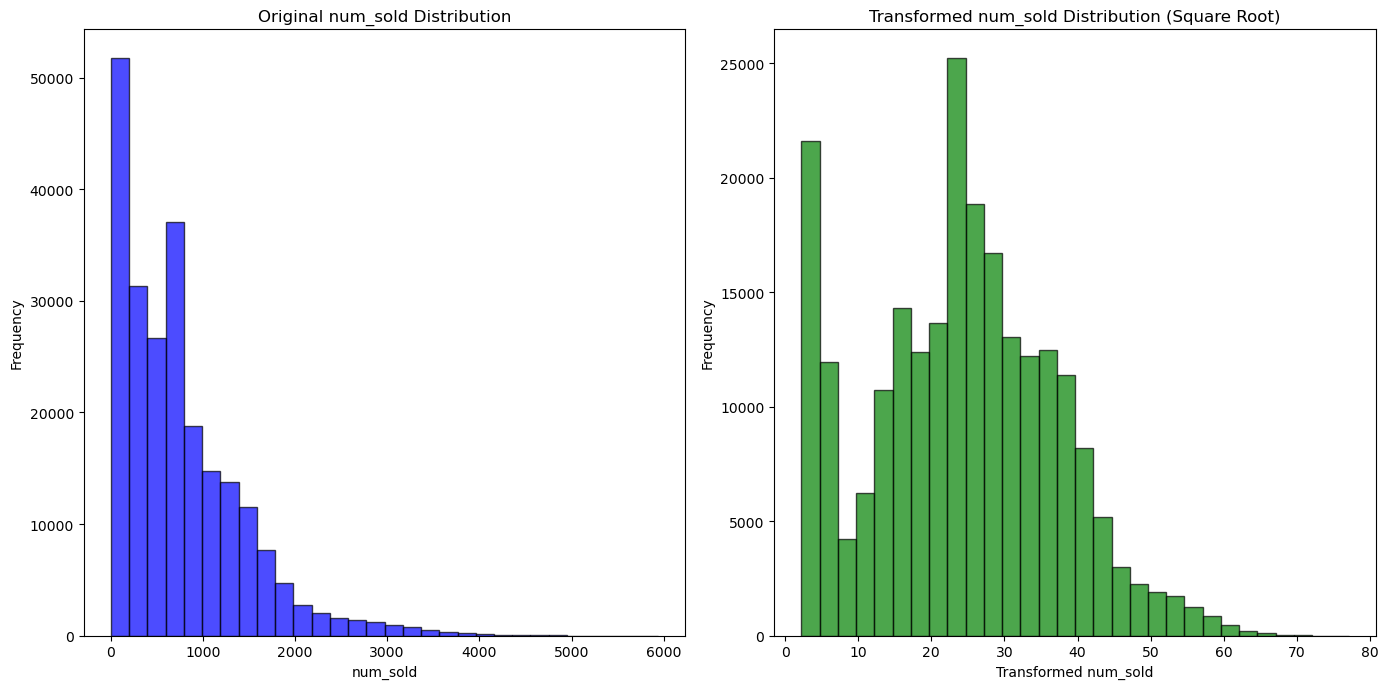

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 取得 num_sold 的數據
y = df['num_sold'].values
y = y[y > 0]  # 確保數據為正數，因為平方根轉換要求數據大於零

# 進行平方根轉換（λ = 0.5）
transformed_y = np.sqrt(y)

# 繪製對照圖：轉換前與轉換後的分佈
plt.figure(figsize=(14, 7))

# 轉換前的數據分佈
plt.subplot(1, 2, 1)
plt.hist(y, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Original num_sold Distribution')
plt.xlabel('num_sold')
plt.ylabel('Frequency')

# 轉換後的數據分佈
plt.subplot(1, 2, 2)
plt.hist(transformed_y, bins=30, color='green', edgecolor='black', alpha=0.7)
plt.title('Transformed num_sold Distribution (Square Root)')
plt.xlabel('Transformed num_sold')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [18]:
df.drop(columns=['date'], inplace=True)

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split

# 對 num_sold 進行平方根轉換
df['num_sold_transformed'] = np.sqrt(df['num_sold'])

# 定義 X 和 Y
X = df[['country', 'store', 'product', 'year', 'month', 'day']]  # 特徵
Y = df['num_sold_transformed']  # 目標變數

# 切割數據為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 顯示切割後的訓練集和測試集大小
print(f"Training data size: {X_train.shape[0]} samples")
print(f"Testing data size: {X_test.shape[0]} samples")

Training data size: 184104 samples
Testing data size: 46026 samples


In [24]:
X_train

,country,store,product,year,month,day
83223,Norway,Discount Stickers,Kerneler,2012,7,13
44320,Italy,Premium Sticker Mart,Holographic Goose,2011,5,8
44288,Canada,Stickers for Less,Kerneler,2011,5,8
203719,Kenya,Discount Stickers,Kerneler Dark Mode,2016,3,13
109741,Italy,Discount Stickers,Kaggle,2013,5,4
...,...,...,...,...,...,...
119879,Singapore,Premium Sticker Mart,Kerneler Dark Mode,2013,8,24
103694,Canada,Premium Sticker Mart,Kerneler Dark Mode,2013,2,26
131932,Singapore,Stickers for Less,Kaggle Tiers,2014,1,5
146867,Singapore,Discount Stickers,Kaggle Tiers,2014,6,20


In [26]:
X_test

,country,store,product,year,month,day
24286,Singapore,Discount Stickers,Kaggle,2010,9,27
94612,Finland,Stickers for Less,Kaggle Tiers,2012,11,17
141575,Canada,Stickers for Less,Holographic Goose,2014,4,23
194079,Italy,Stickers for Less,Kerneler Dark Mode,2015,11,27
152020,Canada,Premium Sticker Mart,Holographic Goose,2014,8,17
...,...,...,...,...,...,...
54186,Canada,Stickers for Less,Kaggle,2011,8,26
179161,Norway,Discount Stickers,Kaggle,2015,6,14
209893,Canada,Premium Sticker Mart,Kerneler,2016,5,21
227046,Norway,Stickers for Less,Kaggle,2016,11,27


In [28]:
import category_encoders as ce

# 創建目標編碼器
target_encoder_train = ce.TargetEncoder(cols=['product'])
X_train['product_encoded'] = target_encoder_train.fit_transform(X_train['product'], y_train)

# 計算 '客戶名稱' 的頻率
customer_freq_train = X_train['country'].value_counts(normalize=True)
X_train['country_encoded'] = X_train['country'].map(customer_freq_train)

# 計算 '原料編號' 的頻率
material_freq_train = X_train['store'].value_counts(normalize=True)
X_train['store_encoded'] = X_train['store'].map(material_freq_train)

In [30]:
X_train.drop(columns=['country'], inplace=True)
X_train.drop(columns=['product'], inplace=True)
X_train.drop(columns=['store'], inplace=True)

X_train

,year,month,day,product_encoded,country_encoded,store_encoded
83223,2012,7,13,21.403316,0.166227,0.332687
44320,2011,5,8,15.388475,0.166547,0.333399
44288,2011,5,8,21.403316,0.166835,0.333915
203719,2016,3,13,23.170913,0.166819,0.332687
109741,2013,5,4,31.912737,0.166547,0.332687
...,...,...,...,...,...,...
119879,2013,8,24,23.170913,0.166732,0.333399
103694,2013,2,26,23.170913,0.166835,0.333399
131932,2014,1,5,29.005065,0.166732,0.333915
146867,2014,6,20,29.005065,0.166732,0.332687


In [32]:
import category_encoders as ce

# 用訓練集的 target_encoder 來轉換測試集
X_test['product_encoded'] = target_encoder_train.transform(X_test['product'])

# 用訓練集的頻率來轉換測試集
X_test['country_encoded'] = X_test['country'].map(customer_freq_train)
X_test['store_encoded'] = X_test['store'].map(material_freq_train)

In [34]:
X_test.drop(columns=['country'], inplace=True)
X_test.drop(columns=['store'], inplace=True)
X_test.drop(columns=['product'], inplace=True)

X_test

,year,month,day,product_encoded,country_encoded,store_encoded
24286,2010,9,27,31.912737,0.166732,0.332687
94612,2012,11,17,29.005065,0.166840,0.333915
141575,2014,4,23,15.388475,0.166835,0.333915
194079,2015,11,27,23.170913,0.166547,0.333915
152020,2014,8,17,15.388475,0.166835,0.333399
...,...,...,...,...,...,...
54186,2011,8,26,31.912737,0.166835,0.333915
179161,2015,6,14,31.912737,0.166227,0.332687
209893,2016,5,21,21.403316,0.166835,0.333399
227046,2016,11,27,31.912737,0.166227,0.333915


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 200}
Best Score (MSE): 3.3813305264356077
Train MSE: 2.836247685768855
Train RMSE: 1.6841162922342552
Train MAE: 1.0072241206036558
Train R²: 0.9825380545692236
Test MSE: 3.215445581852733
Test RMSE: 1.793166356435658
Test MAE: 1.0898074709790602
Test R²: 0.980210419233803


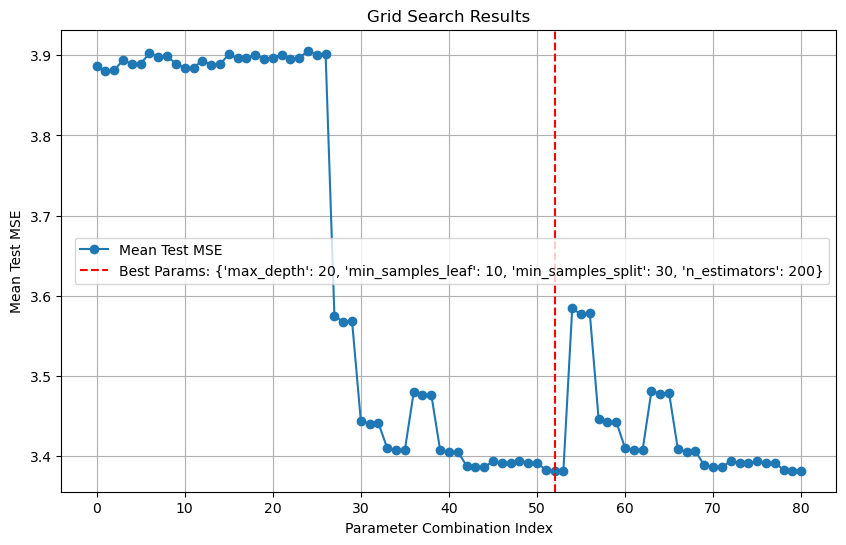

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

# 定義參數網格
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [1, 5, 10]
}

# 創建隨機森林回歸器
rf = RandomForestRegressor(random_state=42)

# 網格搜索
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=3, 
    n_jobs=-1, 
    verbose=0
)
grid_search.fit(X_train, y_train)  # 直接使用原始數據

# 最佳參數和最佳分數
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (MSE):", best_score)

# 使用最佳參數訓練模型
best_rf = grid_search.best_estimator_

# 計算訓練集的評估指標
y_train_pred = best_rf.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = train_mse ** 0.5
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# 計算測試集的評估指標
y_test_pred = best_rf.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = test_mse ** 0.5
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# 輸出結果
print(f"Train MSE: {train_mse}")
print(f"Train RMSE: {train_rmse}")
print(f"Train MAE: {train_mae}")
print(f"Train R²: {train_r2}")

print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test R²: {test_r2}")

# 提取結果進行視覺化
results = grid_search.cv_results_
mean_test_scores = -results['mean_test_score']
params = results['params']

# 創建圖示，顯示每個超參數組合的平均測試分數
plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_test_scores)), mean_test_scores, marker='o', label="Mean Test MSE")
plt.axvline(
    x=np.argmin(mean_test_scores), 
    color='red', linestyle='--', label=f"Best Params: {best_params}"
)
plt.xlabel("Parameter Combination Index")
plt.ylabel("Mean Test MSE")
plt.title("Grid Search Results")
plt.legend()
plt.grid()
plt.show()

Cross-Validation Results:
Mean CV MSE: 3.3741745593172636 ± 0.08461173963085905
Mean CV RMSE: 1.8367479286115032 ± 0.02305658384528273
Mean CV MAE: 1.101271282902047 ± 0.008357483978167927


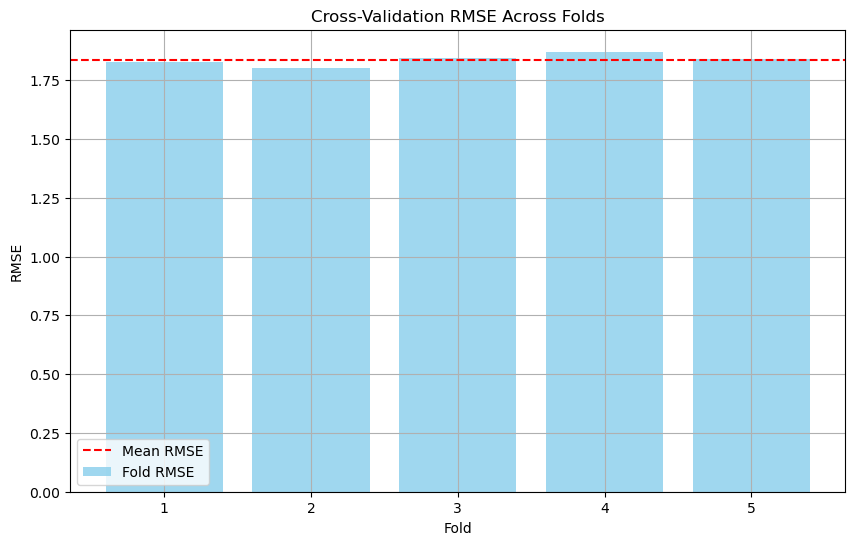

In [41]:
from sklearn.model_selection import cross_val_score

# 使用最佳模型進行交叉驗證
cv_scores = cross_val_score(
    best_rf, 
    X_train, 
    y_train, 
    scoring='neg_mean_squared_error', 
    cv=5, 
    n_jobs=-1
)

# 轉換為正值並計算平均與標準差
cv_mse_scores = -cv_scores
cv_rmse_scores = np.sqrt(cv_mse_scores)
cv_mae_scores = cross_val_score(
    best_rf, 
    X_train, 
    y_train, 
    scoring='neg_mean_absolute_error', 
    cv=5, 
    n_jobs=-1
)
cv_mae_scores = -cv_mae_scores

# 輸出交叉驗證結果
print("Cross-Validation Results:")
print(f"Mean CV MSE: {np.mean(cv_mse_scores)} ± {np.std(cv_mse_scores)}")
print(f"Mean CV RMSE: {np.mean(cv_rmse_scores)} ± {np.std(cv_rmse_scores)}")
print(f"Mean CV MAE: {np.mean(cv_mae_scores)} ± {np.std(cv_mae_scores)}")

# 視覺化交叉驗證結果
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), cv_rmse_scores, color='skyblue', alpha=0.8, label='Fold RMSE')
plt.axhline(np.mean(cv_rmse_scores), color='red', linestyle='--', label='Mean RMSE')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Cross-Validation RMSE Across Folds')
plt.legend()
plt.grid()
plt.show()

In [47]:
# 生成新的特徵名稱列表
feature_names = X_train.columns.tolist()
print("Updated Feature Names:", feature_names)

Updated Feature Names: ['year', 'month', 'day', 'product_encoded', 'country_encoded', 'store_encoded']


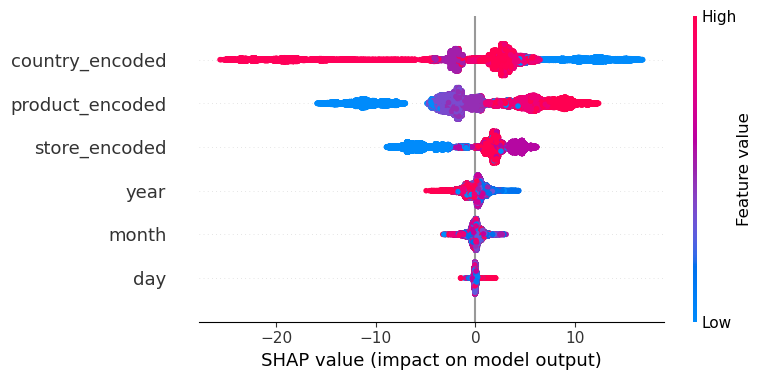

In [49]:
import fasttreeshap
import shap

# 建立 FastTreeExplainer 解釋器
explainer = fasttreeshap.TreeExplainer(best_rf)  # 使用 FastTreeShap 加速 SHAP 計算
shap_values = explainer.shap_values(X_test)  # 計算 SHAP 值

# 繪製 SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [52]:
import pandas as pd

# 將 SHAP 值轉為 DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_train.columns)

# 計算每個特徵的 SHAP 統計指標
shap_stats = pd.DataFrame({
    "Feature": shap_df.columns,
    "Mean SHAP Value": shap_df.mean().values,
    "Max SHAP Value": shap_df.max().values,
    "Min SHAP Value": shap_df.min().values
}).sort_values(by="Mean SHAP Value", ascending=False)

# 顯示結果
print(shap_stats)

           Feature  Mean SHAP Value  Max SHAP Value  Min SHAP Value
3  product_encoded         0.029828       12.374198      -15.894514
4  country_encoded         0.018540       16.791752      -25.654755
1            month         0.008225        3.084744       -3.286500
0             year        -0.000404        4.354148       -4.955935
2              day        -0.001841        2.032800       -1.500856
5    store_encoded        -0.031079        6.161510       -8.939133


shap_values.shape: (46026, 6)
X_test.shape: (46026, 6)


invalid value encountered in divide


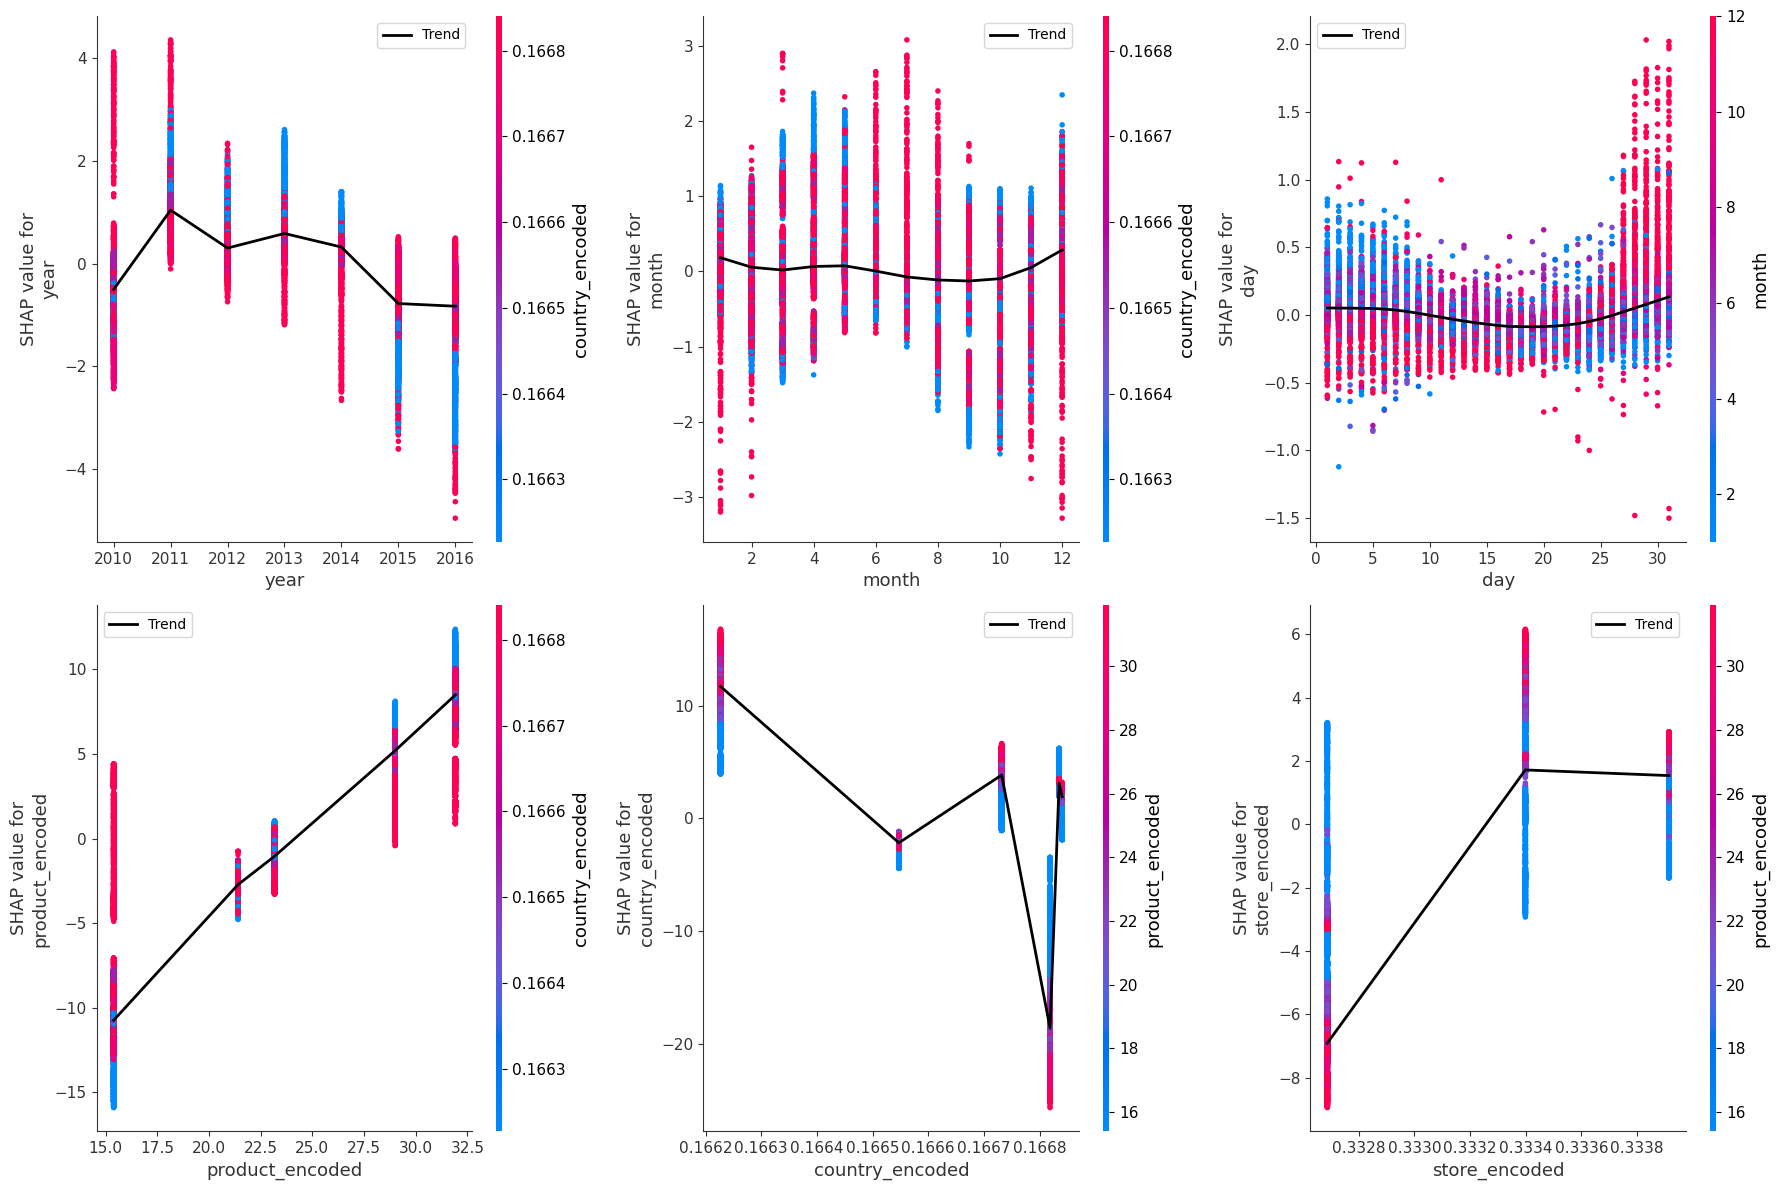

In [57]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 確保 X_test 和 shap_values 類型一致
X_test = X_test.astype(np.float64)

# 確保 shap_values 是 numpy 陣列（適用回歸問題）
if isinstance(shap_values, shap.Explanation):
    shap_values = shap_values.values  # 提取真正的 SHAP 值

# 檢查形狀
print("shap_values.shape:", shap_values.shape)
print("X_test.shape:", X_test.shape)

# 確保 SHAP 值與特徵數量一致
assert shap_values.shape == X_test.shape, "SHAP 值形狀與 X_test 不匹配！"

# 繪製 SHAP 依賴圖
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, feature in enumerate(X_test.columns[:6]):  # 只繪製前 9 個特徵
    row, col = divmod(i, 3)
    ax = axes[row, col]

    shap.dependence_plot(
        feature, shap_values, X_test, ax=ax, show=False
    )

    # 加上 LOESS 平滑曲線
    feature_values = X_test[feature].values
    shap_values_feature = shap_values[:, i]

    smoothed = sm.nonparametric.lowess(shap_values_feature, feature_values, frac=0.3)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='black', linewidth=2, label="Trend")

    ax.legend()

plt.tight_layout()
plt.show()